In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import time
from tqdm.autonotebook import tqdm
import gym
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def moving_average(values, n=100) :
    ret = np.cumsum(values, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
env = gym.make('Taxi-v2')
CHECKPOINT_DIR = 'checkpoints'
MAX_STEPS = env.spec.timestep_limit
NUM_EPISODES = 50000
GAMMA = 0.95
START_ALPHA = 0.1
ALPHA_TAPER = 0.01
START_EPSILON = 1
EPSILON_TAPER = 0.01

In [4]:
obs_dim = env.observation_space.n # size of our state
action_dim = env.action_space.n # number of actions
# Initialize our Q table
Q = np.zeros((obs_dim, action_dim))

# we're going to keep track of how many times each Q(s,a) is updated
# this is for our adaptive learning rate
state_visit_counts = {}
update_counts = np.zeros((obs_dim, action_dim), dtype=np.dtype(int))

In [5]:
## heart of algorithm
def update_Q(prev_state,action,reward,cur_state):
    alpha = START_ALPHA / (1.0 + update_counts[prev_state][action] * ALPHA_TAPER )
    update_counts[prev_state][action] += 1
    Q[prev_state][action] += alpha * ( reward + GAMMA * np.max(Q[cur_state]) - Q[prev_state][action] )
    
def epsilon_action(s, eps=START_EPSILON):
    if np.random.random() < (1 - eps):
        return np.argmax(Q[s])
    else:
        return env.action_space.sample()

Episode = 0  |  Avg Reward = 0.0  | Epsilon = 1.0
Episode = 1000  |  Avg Reward = -167.551  | Epsilon = 0.09090909090909091
Episode = 2000  |  Avg Reward = -0.523  | Epsilon = 0.047619047619047616
Episode = 3000  |  Avg Reward = 6.135  | Epsilon = 0.03225806451612903
Episode = 4000  |  Avg Reward = 7.154  | Epsilon = 0.024390243902439025
Episode = 5000  |  Avg Reward = 7.178  | Epsilon = 0.0196078431372549
Episode = 6000  |  Avg Reward = 7.425  | Epsilon = 0.01639344262295082
Episode = 7000  |  Avg Reward = 7.74  | Epsilon = 0.014084507042253521
Episode = 8000  |  Avg Reward = 8.002  | Epsilon = 0.012345679012345678
Episode = 9000  |  Avg Reward = 8.071  | Epsilon = 0.01098901098901099
Episode = 10000  |  Avg Reward = 7.982  | Epsilon = 0.009900990099009901
Episode = 11000  |  Avg Reward = 8.112  | Epsilon = 0.009009009009009009
Episode = 12000  |  Avg Reward = 8.043  | Epsilon = 0.008264462809917356
Episode = 13000  |  Avg Reward = 8.129  | Epsilon = 0.007633587786259542
Episode = 140

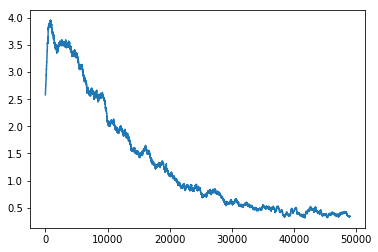

In [6]:
total_reward = 0
deltas = []

for episode in tqdm(range(NUM_EPISODES), desc="EPISODES COMPLETE"):
    # Taper EPSILON each episode
    eps = START_EPSILON / (1.0 + episode * EPSILON_TAPER)

    if episode % 1000 == 0:
        print("Episode =", episode, " |  Avg Reward =", total_reward/1000, " | Epsilon =", eps)
        total_reward = 0

    biggest_change = 0
    curr_state = env.reset()
    for step in range(MAX_STEPS):
        prev_state = curr_state
        state_visit_counts[prev_state] = state_visit_counts.get(prev_state,0) + 1
        action = epsilon_action(curr_state, eps)
        curr_state, reward, done, info = env.step(action)
        total_reward += reward
        old_qsa = Q[prev_state][action]
        update_Q(prev_state, action, reward, curr_state)
        biggest_change = max(biggest_change, np.abs(old_qsa - Q[prev_state][action]))
        if done:
            break
    
    deltas.append(biggest_change)

mean_state_visit = np.mean(list(state_visit_counts.values()))
print("Each state was visited on average {} times.".format(mean_state_visit))

plt.plot(moving_average(deltas,n=1000))
plt.show()

In [7]:
curr = env.reset()
total_reward= 0
while True:
    env.render()
    action = np.argmax(Q[curr])
    curr,reward,done,_ = env.step(action)
    total_reward+=reward
    if done:
        break
env.render()
env.reset()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
|_| : | : |
|Y| : |B: |


443